In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os 
import numpy as np
import matplotlib.image as mpimg
import seaborn as sns
from glob import glob
import PIL
from tifffile import imread
from tqdm import tqdm
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import f1_score, make_scorer
import tensorflow as tf
from tensorflow.keras import layers, models

In [22]:
label_df = pd.read_csv('labelled.csv', index_col='id')
y = label_df['label'].values 

label
0     15
1     15
2     15
3     15
4     15
5     15
6     15
7     15
8     15
9     15
10    15
11    15
12    15
13    15
Name: count, dtype: int64


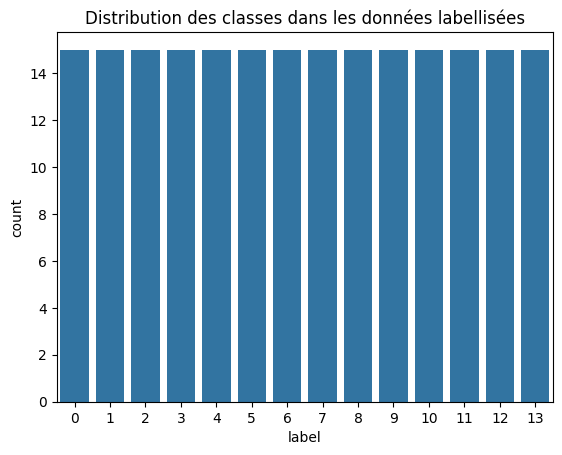

In [3]:
print(label_df['label'].value_counts().sort_index())
sns.countplot(x=label_df['label'])
plt.title("Distribution des classes dans les données labellisées")
plt.show()

In [4]:
!dir

 Le volume dans le lecteur C n'a pas de nom.
 Le num�ro de s�rie du volume est A87D-C554

 R�pertoire de c:\Users\gerar\Desktop\githubRepo\-AI-Projects\BYU - Locating Bacterial Flagellar Motors 2025

22/05/2025  11:33    <DIR>          .
22/05/2025  11:54    <DIR>          ..
22/05/2025  11:31             5�193 foram_metric.py
22/05/2025  11:31             3�639 labelled.csv
22/05/2025  12:09           788�183 model.ipynb
22/05/2025  11:31           139�786 sample_submission.csv
22/05/2025  11:31           116�411 unlabelled.csv
22/05/2025  11:31    <DIR>          visualizations
22/05/2025  11:33    <DIR>          volumes
               5 fichier(s)        1�053�212 octets
               4 R�p(s)  13�474�697�216 octets libres


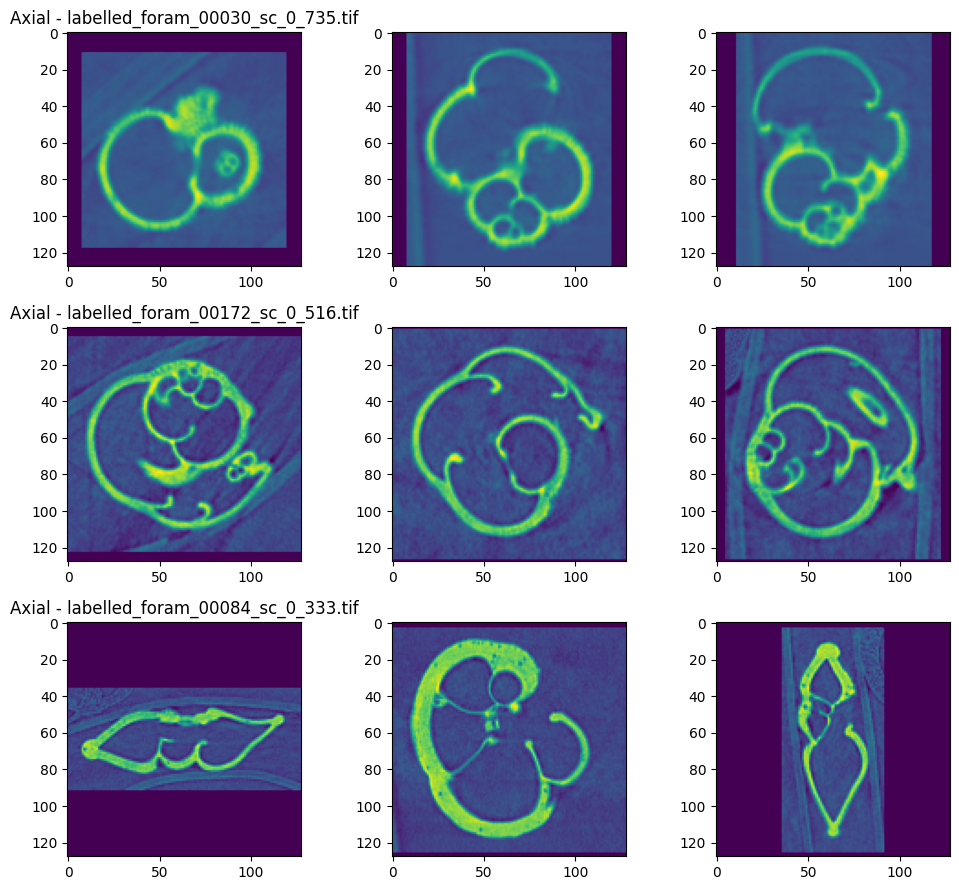

In [23]:
def show_random_slices(n=3):
    sample_paths = sorted(glob('volumes/volumes/labelled/*.tif'))
    np.random.seed(42)
    random_paths = np.random.choice(sample_paths, size=n, replace=False)

    fig, axs = plt.subplots(n, 3, figsize=(10, 3 * n))
    for i, path in enumerate(random_paths):
        volume = imread(path)
        axs[i, 0].imshow(volume[64])  
        axs[i, 1].imshow(volume[:, 64, :]) 
        axs[i, 2].imshow(volume[:, :, 64])  
        axs[i, 0].set_title(f'Axial - {os.path.basename(path)}')
    plt.tight_layout()
    plt.show()

show_random_slices()


In [24]:
def make_feature_array(vol_list):
    r0 = np.square(np.arange(128) - 63.5)
    r = r0.reshape(-1, 1, 1) + r0.reshape(1, -1, 1) + r0.reshape(1, 1, -1)
    X = np.full((len(vol_list), 14), np.nan)
    for i, filename in enumerate(tqdm(vol_list)):
        volume = imread(filename)
        X[i] = np.array([
            volume.mean(),
            volume[volume > 0].mean() if (volume > 0).any() else 0,
            volume.max(axis=0).mean(),
            volume.max(axis=1).mean(),
            volume.max(axis=2).mean(),
            volume.max(axis=1).max(axis=0).mean(),
            volume.max(axis=2).max(axis=1).mean(),
            volume.max(axis=2).max(axis=0).mean(),
            (r * volume).mean(),
            (volume != 0).mean(),
            np.abs(np.diff(volume, axis=0)).mean(),
            np.abs(np.diff(volume, axis=1)).mean(),
            np.abs(np.diff(volume, axis=2)).mean(),
            float(filename.split('_sc_')[1].replace('.tif', '').replace('_', '.')) if '_sc_' in filename else 0,
        ])
    return X

In [25]:
volume_paths = sorted(glob('volumes/volumes/labelled/*.tif'))
X = make_feature_array(volume_paths)

100%|██████████| 210/210 [00:06<00:00, 32.14it/s]


In [26]:
X.shape

(210, 14)

Model ML

In [8]:


clf = RandomForestClassifier(n_estimators=100, random_state=42)
scores = cross_val_score(clf, X, y, cv=5, scoring='f1_macro')

In [9]:
print("F1 Macro:", scores.mean())


F1 Macro: 0.3542321170892599


In [10]:
def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 300)
    max_depth = trial.suggest_int("max_depth", 5, 50)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None])
    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42,
        n_jobs=-1,
    )
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(clf, X, y, cv=cv, scoring=make_scorer(f1_score, average="macro"))
    return scores.mean()

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

best_params = study.best_params
print(best_params)

best_clf = RandomForestClassifier(**best_params, random_state=42, n_jobs=-1)
best_clf.fit(X, y)

[I 2025-05-22 12:09:30,765] A new study created in memory with name: no-name-e31e571a-6cf1-4143-959e-4ff30c7c9e67
[I 2025-05-22 12:09:31,401] Trial 0 finished with value: 0.2955019583591012 and parameters: {'n_estimators': 88, 'max_depth': 9, 'min_samples_split': 11, 'min_samples_leaf': 9, 'max_features': 'log2'}. Best is trial 0 with value: 0.2955019583591012.
[I 2025-05-22 12:09:32,198] Trial 1 finished with value: 0.31504844361987216 and parameters: {'n_estimators': 119, 'max_depth': 42, 'min_samples_split': 20, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 1 with value: 0.31504844361987216.
[I 2025-05-22 12:09:33,652] Trial 2 finished with value: 0.33413134484563056 and parameters: {'n_estimators': 240, 'max_depth': 23, 'min_samples_split': 16, 'min_samples_leaf': 8, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.33413134484563056.
[I 2025-05-22 12:09:34,864] Trial 3 finished with value: 0.32106052677481245 and parameters: {'n_estimators': 195, 'max_depth': 

{'n_estimators': 279, 'max_depth': 33, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_features': None}


RandomForestClassifier(max_depth=33, max_features=None, min_samples_leaf=4,
                       min_samples_split=6, n_estimators=279, n_jobs=-1,
                       random_state=42)

In [12]:
test_paths = sorted(glob('volumes/volumes/unlabelled/*.tif'))
X_test = make_feature_array(test_paths)
y_pred = best_clf.predict(X_test)



100%|██████████| 18216/18216 [10:19<00:00, 29.40it/s]


In [13]:
unlabelled_index = pd.read_csv('unlabelled.csv', index_col='id').index
submission = pd.Series(y_pred, index=unlabelled_index[:len(y_pred)], name='label')
submission.to_csv('submission.csv')